In [390]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

In [883]:
ev_signals = pd.read_csv('C:\\Users\\bfesc\\Documents\\Master_thesis\\master_data\\dataport\\dataport-ev-signals.csv', 
                header = 0, index_col = 0)
grid_signals = pd.read_csv('C:\\Users\\bfesc\\Documents\\Master_thesis\\master_data\\dataport\\dataport-ev-grid-signals.csv', 
                header = 0, index_col = 0)

print(ev_signals.shape, grid_signals.shape)

(43, 35016) (43, 35016)


In [16]:
def get_signatures(power_series, min_off_duration = 0, min_on_duration = 3):
    
    signatures = []
    current_signal = []
    starts = []
    peak_times = []
    off_duration = 0
    
    for i in range(1,power_series.size):

        if power_series[i] > 1:
            if len(current_signal) == 0:
                if i == 0:
                    current_signal.append(0)
                else:
                    current_signal.append(power_series[i-1])
            current_signal.append(power_series[i])
            off_duration = 0
        else:
            off_duration += 1
            if off_duration >= min_off_duration and len(current_signal) > min_on_duration:
                if i >= len(current_signal) - 1:
                    current_signal.append(0)
                else:
                    current_signal.append(power_series[i+1])
                signatures.append(current_signal)
                starts.append(power_series.index[i-len(current_signal)])
                peak_times.extend(power_series.index[i-len(current_signal):i])
                current_signal = []
            
    return signatures, pd.to_datetime(starts), pd.to_datetime(peak_times)


In [278]:
N = ev_signals.index.size
signatures = []
signature_starts = []
charging_times = []
significance_threshold = 50

for i in range(N):
    s, starts, peak_times = get_signatures(ev_signals.iloc[i])
    if len(starts) > significance_threshold:
        signatures.append(s)
        signature_starts.append(starts)
        charging_times.append(peak_times)



# Timing aspects

In [422]:
time_of_day_start = []
tofs_flat = []
N2 = len(signature_starts)

for i in range(N2):
    time_of_day_start.append(signature_starts[i].hour)
    tofs_flat.extend(signature_starts[i].hour)

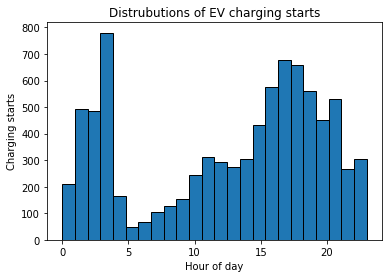

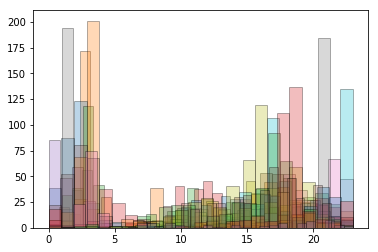

In [884]:
plt.hist(tofs_flat, bins=24, edgecolor='black')
plt.title("Distrubutions of EV charging starts")
plt.xlabel("Hour of day")
plt.ylabel("Charging starts")
plt.show()

for t in time_of_day_start:
    plt.hist(t, alpha=0.3, edgecolor='black', bins=24)
plt.show()

In [440]:
time_of_day = []
tof_flat = []

for i in range(N2):
    time_of_day.append(charging_times[i].hour)
    tof_flat.extend(charging_times[i].hour)

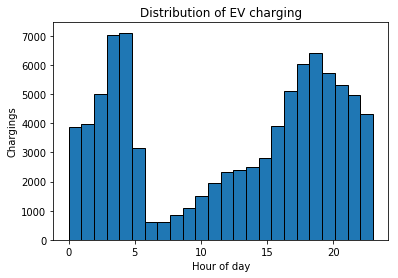

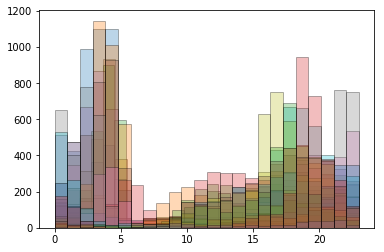

In [471]:
plt.hist(tof_flat, bins=24, edgecolor='black')
plt.title("Distribution of EV charging")
plt.ylabel("Chargings")
plt.xlabel("Hour of day")
plt.savefig('C:\\Users\\bfesc\\Documents\\Master_thesis\\figs\\EV_stats\\EV-charging-times.svg')
plt.show()

for t in time_of_day:
    plt.hist(t, alpha=0.3, edgecolor='black', bins=24)
plt.show()

In [453]:
time_of_day_mean = []
time_of_day_mode = []

for i in range(N2):
    time_of_day_mean.append(np.mean(charging_times[i].hour))
    time_of_day_mode.append(np.argmax(plt.hist(charging_times[i].hour, bins=24, range=[0,23])[0]))

In [457]:
time_of_day_start_mean = []
time_of_day_start_mode = []

for i in range(N2):
    time_of_day_start_mean.append(np.mean(signature_starts[i].hour))
    time_of_day_start_mode.append(np.argmax(plt.hist(signature_starts[i].hour, bins=24, range=[0,23])[0]))

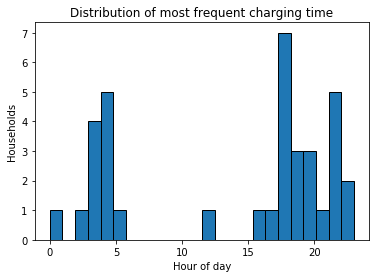

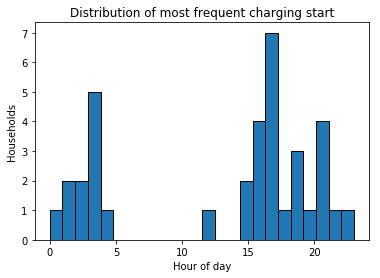

In [1029]:
plt.hist(time_of_day_mode, bins=24, range=[0,23], edgecolor='black')
plt.title("Distribution of most frequent charging time")
plt.xlabel("Hour of day")
plt.ylabel("Households")
plt.savefig('C:\\Users\\bfesc\\Documents\\Master_thesis\\figs\\EV_stats\\EV-charging-times-by-household.svg')
plt.show()
plt.hist(time_of_day_start_mode, bins=24, range=[0,23], edgecolor='black')
plt.title("Distribution of most frequent charging start")
plt.xlabel("Hour of day")
plt.ylabel("Households")
plt.show()

# Charging frequency

In [530]:
time_between_chargings = []
print(N2)

for i in range(N2):
    t1 = signature_starts[i][:-1]
    t2 = signature_starts[i][1:]
    time_between_chargings.append((t2-t1).astype('timedelta64[h]'))
#     for j in range(1,len(signature_starts[i])):
#         time_between_chargings.append(signature_starts[i][j] - signature_starts[i][j-1])

36


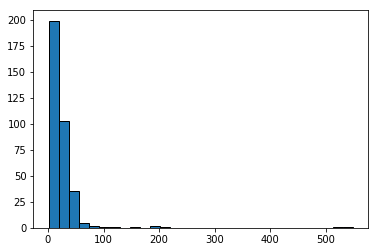

In [531]:
plt.hist(time_between_chargings[2], bins=30, edgecolor='black')
plt.show()

In [532]:
print("95th percentile: ", np.percentile(time_between_chargings[1],95))
print("Two standard deviations from mean: ", np.mean(time_between_chargings[1]) + 2*np.std(time_between_chargings[1]))
print("Two weeks: ", 24*14)

95th percentile:  81.6
Two standard deviations from mean:  91.5808803378
Two weeks:  336


## Handling outliers
Sometimes people go on holidays, or do other things for an extended period during which they do not charge their cars. While probably interesting in their own right, these periods are outliers for the purpose of establishing mean baseline charging frequencies, and should be removed. The choice then, is between statistical methods and a simple threshold for determining outliers. A simple threshold could be, say, assuming that if a car is not charged for two weeks, then the owner has definitely gone somewhere and the interval should be discarded. Statistically, one can set a threshold at the 95th percentile, or at three standard deviations to retain approximately 95% of the signals and leave the outliers. <br>
For comparisons between houses, the latter method may yield more robust results. 

In [604]:
time_between_chargings_r = np.copy(time_between_chargings)

for i in range(N2):
    #two_std = np.mean(time_between_chargings[i]) + 2*np.std(time_between_chargings[i])
    one_week = 24*7
    time_between_chargings[i] = time_between_chargings[i][np.where(time_between_chargings[i] > 0)]
    time_between_chargings_r[i] = time_between_chargings[i][np.where(time_between_chargings[i] < one_week)]
    time_between_chargings_r[i] = time_between_chargings_r[i].tolist()
    time_between_chargings[i] = time_between_chargings[i].tolist()

In [1015]:
from scipy.stats import mode

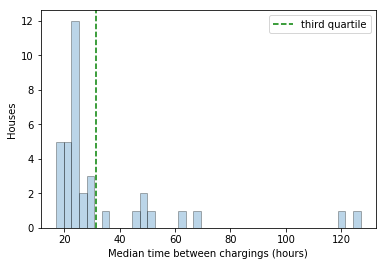

61.1% of households typically charge at least once a day,
    86.1% of households typically charge at least once every other day


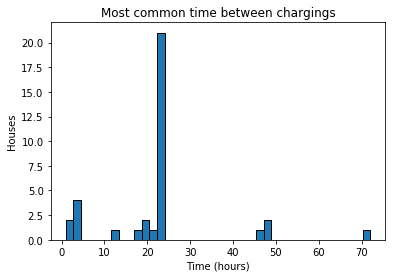

In [1030]:
mean_interval = []
median_interval = []
mode_interval = []

for t in time_between_chargings:
    mean_interval.append(np.mean(t))
    median_interval.append(np.median(t))
    mode_interval.append(mode(t)[0][0])

plt.hist(median_interval, alpha=0.3, edgecolor='black', bins=40)
# plt.axvline(np.mean(median_interval), color='red', linestyle='--', label='Mean')
# plt.axvline(np.median(median_interval), color='blue', linestyle='--', label='Median')
plt.axvline(np.percentile(median_interval,75), color='green', linestyle='--', label='third quartile')
plt.legend()
plt.xlabel("Median time between chargings (hours)")
plt.ylabel("Houses")
plt.show()
print("{0:.1f}% of households typically charge at least once a day,\n\
    {1:.1f}% of households typically charge at least once every other day".format((np.size(np.where(np.array(median_interval) <= 24))/N2)*100,
                                                                                   (np.size(np.where(np.array(median_interval) <= 48))/N2)*100))

plt.hist(mode_interval, alpha=1, edgecolor='black', bins=40)
# plt.axvline(np.mean(median_interval), color='red', linestyle='--', label='Mean')
# plt.axvline(np.median(median_interval), color='blue', linestyle='--', label='Median')
#plt.axvline(np.percentile(mode_interval,75), color='green', linestyle='--', label='third quartile')
#plt.legend()
plt.title("Most common time between chargings")
plt.xlabel("Time (hours)")
plt.ylabel("Houses")
plt.savefig('C:\\Users\\bfesc\\Documents\\Master_thesis\\figs\\EV_stats\\mode_inter_charging_time.svg')
plt.show()


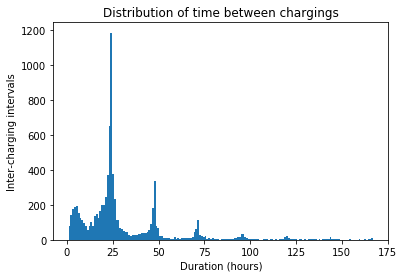

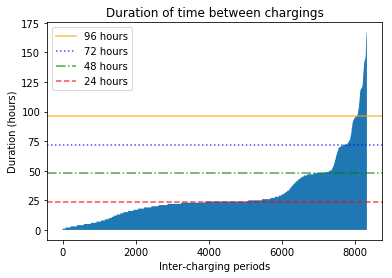

largest bin:  23.7261904762  -  24.7142857143
Proportion of periods in largest bin:  0.142548076923
Proportion of periods shorter than one week:  0.0197926484449


In [575]:
tbc_flat = []
n_periods = np.sum([len(t) for t in time_between_chargings])

for t in time_between_chargings_r:
    tbc_flat.extend(t)

hist = plt.hist(tbc_flat,bins=24*7)
plt.title("Distribution of time between chargings")
plt.ylabel("Inter-charging intervals")
plt.xlabel("Duration (hours)")
plt.savefig('C:\\Users\\bfesc\\Documents\\Master_thesis\\figs\\EV_stats\\EV-inter-charging-distribution.png')
plt.show()

plt.fill_between(np.arange(len(tbc_flat)),np.zeros(len(tbc_flat)),np.sort(tbc_flat))
plt.axhline(96, color='orange', label='96 hours', linestyle='-', alpha=0.7)
plt.axhline(72, color='blue', label='72 hours', linestyle=':', alpha=0.7)
plt.axhline(48, color='green', label='48 hours', linestyle='-.', alpha=0.7)
plt.axhline(24, color='red', label='24 hours', linestyle='--', alpha=0.7)
plt.legend(loc='upper left', ncol=1)
plt.title("Duration of time between chargings")
plt.ylabel("Duration (hours)")
plt.xlabel("Inter-charging periods")
plt.savefig('C:\\Users\\bfesc\\Documents\\Master_thesis\\figs\\EV_stats\\EV-inter-charging-periods.png')
plt.show()

largest = np.argmax(hist[0])
print("largest bin: ", hist[1][largest], " - ", hist[1][largest+1])
print("Proportion of periods in largest bin: ", np.max(hist[0])/np.size(tbc_flat))
print("Proportion of periods shorter than one week: ", 1-(len(tbc_flat)/n_periods))

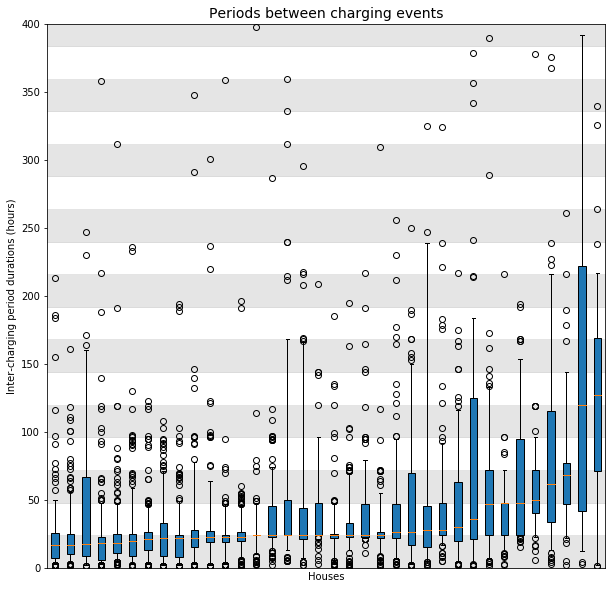

In [661]:
median_interval_f = []
for t in time_between_chargings:
    median_interval_f.append(np.median(t))
sorted_by_median = np.argsort(median_interval_f)

fig, axarr = plt.subplots(1,1)
fig.set_size_inches(10,10)
axarr.boxplot(np.array(time_between_chargings)[sorted_by_median], whis=[5,95], patch_artist=True)
#axarr.axhline(np.median(median_interval), color='red', linestyle='--')
plt.ylim(0,400)
cmap = ['grey','white']
for i in range(18):
    plt.fill_between(np.arange(N2+2),np.ones(N2+2)*24*i,np.ones(N2+2)*24*(i+1),alpha=0.2, color=cmap[i%2], edgecolor='black')

plt.xticks([])
plt.xlabel("Houses")
plt.ylabel("Inter-charging period durations (hours)")
plt.title("Periods between charging events", fontsize=14)
plt.savefig('C:\\Users\\bfesc\\Documents\\Master_thesis\\figs\\EV_stats\\EV-inter-charging-boxplot.png')
#plt.legend(loc='upper left')
plt.show()

### Going forward
Something about the fourier transform?

C:\Users\bfesc\Anaconda3\lib\site-packages\numpy\core\numeric.py:531: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


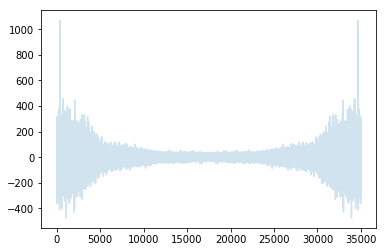

364

In [287]:
plt.plot(np.fft.fft(ev_signals.iloc[0])[1:], alpha=0.2)
plt.show()
np.argmax(np.fft.fft(ev_signals.iloc[0][1:])[1:])


# Charging duration

In [689]:
ct_flat = []
for t in charging_times:
    ct_flat.extend(t)

charging_durations = []

i=0

while i < len(ct_flat):
    l = i
    while l+1 < len(ct_flat) and ct_flat[l+1] - ct_flat[l] == pd.Timedelta('15m'):
        l+=1

    if l > i:
        charging_durations.append(l-i)
    
    i = l + 1

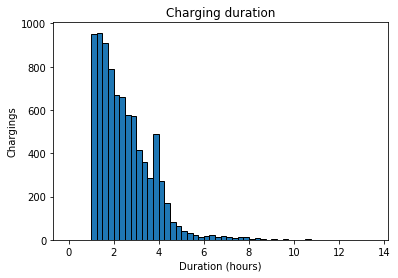

In [1033]:
plt.hist(np.array(charging_durations)/4, bins=int(max(charging_durations)), edgecolor='black', range = (0,max(charging_durations)/4))
plt.title("Charging duration")
plt.xlabel("Duration (hours)")
plt.ylabel("Chargings")
plt.savefig('C:\\Users\\bfesc\\Documents\\Master_thesis\\figs\\EV_stats\\all-charging-times.svg')

plt.show()

In [701]:
cd_by_house = []

for h in charging_times:
    house_cd = []
    
    i = 0
    while i < len(h):
        l = i

        while l+1 < len(h) and h[l+1] - h[l] == pd.Timedelta('15m'):
            l+=1

        if l > i:
            house_cd.append(l-i)

        i = l + 1
        
    cd_by_house.append(house_cd)


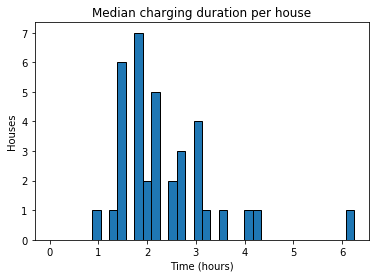

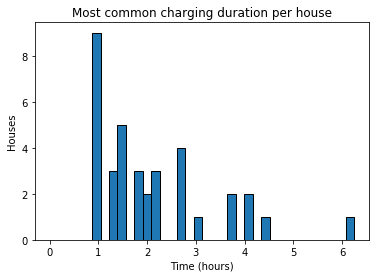

In [1032]:
median_charging_times = [np.median(h)/4 for h in cd_by_house]

plt.hist(median_charging_times, bins=36, range=[0,max(median_charging_times)], edgecolor='black')
plt.title("Median charging duration per house")
plt.xlabel("Time (hours)")
plt.ylabel("Houses")
plt.savefig('C:\\Users\\bfesc\\Documents\\Master_thesis\\figs\\EV_stats\\median-charging-time.svg')

plt.show()

mode_charging_times = [mode(h)[0][0]/4 for h in cd_by_house]

plt.hist(mode_charging_times, bins=36, range=[0,max(mode_charging_times)], edgecolor='black')
plt.title("Most common charging duration per house")
plt.xlabel("Time (hours)")
plt.ylabel("Houses")
plt.savefig('C:\\Users\\bfesc\\Documents\\Master_thesis\\figs\\EV_stats\\mode-charging-time.svg')

plt.show()

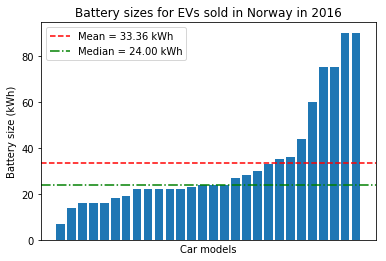

In [762]:
battery_sizes = np.array([90,60,75,90,75,44,35,33,28,30,22,36,27,24,24,22,24,22,22,22,16,23,16,19,16,18,14,7])
battery_sizes.sort()
plt.bar(np.arange(len(battery_sizes)),battery_sizes)
plt.title("Battery sizes for EVs sold in Norway in 2016")
plt.ylabel("Battery size (kWh)")
plt.xlabel("Car models")
plt.xticks([])
plt.axhline(battery_sizes.mean(), color='red', linestyle='--', label='Mean = {0:.2f} kWh'.format(battery_sizes.mean()))
plt.axhline(np.median(battery_sizes), color='green', linestyle='-.', label='Median = {0:.2f} kWh'.format(np.median(battery_sizes)))
plt.legend()
plt.savefig('C:\\Users\\bfesc\\Documents\\Master_thesis\\figs\\EV_stats\\EV-battery-sizes.svg')

plt.show()

# Examining peaks
Next I will attempt to examine the relationship between spikes in grid power drain and EV-charging events.

In [886]:
ev_peak_ratio_1 = np.zeros(N)
ev_peak_ratio_2 = np.zeros(N)
ev_peak_ratio_3 = np.zeros(N)
ev_peak_ratio_4 = np.zeros(N)

for i in range(N):
    s, starts, peak_times = get_signatures(ev_signals.iloc[i])
    
    if len(starts) > significance_threshold:
        grid_mean = np.mean(grid_signals.iloc[i])
        std = np.std(grid_signals.iloc[i])
        
        grid_peaks_1 = pd.to_datetime(grid_signals.columns[np.where(grid_signals.iloc[i] > grid_mean + std)])
        grid_peaks_2 = pd.to_datetime(grid_signals.columns[np.where(grid_signals.iloc[i] > grid_mean + 2*std)])
        grid_peaks_3 = pd.to_datetime(grid_signals.columns[np.where(grid_signals.iloc[i] > grid_mean + 3*std)])
        
        ev_peaks_1 = grid_peaks_1[np.where(np.in1d(grid_peaks_1,peak_times))]
        ev_peaks_2 = grid_peaks_2[np.where(np.in1d(grid_peaks_2,peak_times))]
        ev_peaks_3 = grid_peaks_3[np.where(np.in1d(grid_peaks_3,peak_times))]
        
        ev_peak_ratio_1[i] += len(ev_peaks_1) / len(grid_peaks_1)
        ev_peak_ratio_2[i] += len(ev_peaks_2) / len(grid_peaks_2)
        ev_peak_ratio_3[i] += len(ev_peaks_3) / len(grid_peaks_3)

    else:
        ev_peak_ratio_1[i] += -1
        ev_peak_ratio_2[i] += -1
        ev_peak_ratio_3[i] += -1
        ev_peak_ratio_4[i] += -1
        

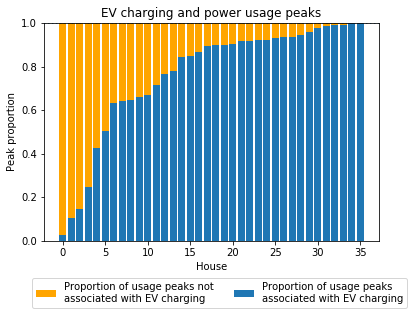

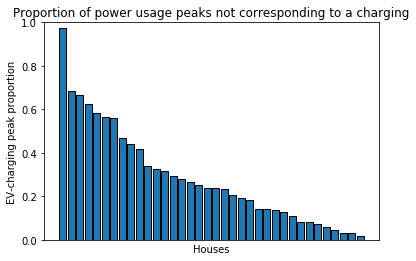

Averages:
0.544523688163
0.289766666679
0.237228246083


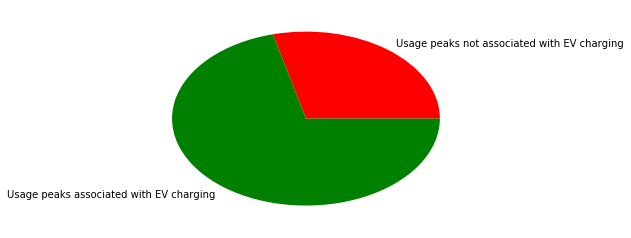

In [1011]:
plt.bar(np.arange(N-7), np.ones(N-7), color='orange', label='Proportion of usage peaks not\nassociated with EV charging')
plt.bar(np.arange(N-7),np.sort(ev_peak_ratio_3[np.where(ev_peak_ratio_3 > 0)]), color='C0', label='Proportion of usage peaks\nassociated with EV charging')
lgd = plt.legend(bbox_to_anchor=(1.1,-0.15), ncol=2)
plt.ylim(0.0,1.0)
plt.axhline(1, linestyle=':')
plt.xlabel("House")
plt.ylabel("Peak proportion")
plt.title("EV charging and power usage peaks")
plt.savefig('C:\\Users\\bfesc\\Documents\\Master_thesis\\figs\\EV_stats\\charging_and_peaks.svg', bbox_extra_artists=(lgd,), bbox_inches='tight')
plt.show()

# plt.bar(np.arange(N-7), np.ones(N-7),color='green',edgecolor=None)
#plt.bar(np.arange(N-7),1-np.sort(ev_peak_ratio_1[np.where(ev_peak_ratio_1 > 0)]), label='Proportion of peaks larger than one\nstandard deviations from mean')
plt.bar(np.arange(N-7),1-np.sort(ev_peak_ratio_2[np.where(ev_peak_ratio_2 > 0)]), 
        label='Proportion of peaks larger than two\nstandard deviations from mean',
        color=None, edgecolor='black')
#plt.bar(np.arange(N-7),1-np.sort(ev_peak_ratio_3[np.where(ev_peak_ratio_3 > 0)]), label='Proportion of peaks larger than three\nstandard deviations from mean')
plt.ylim(0,1)
plt.xticks([])
plt.xlabel("Houses")
plt.ylabel("EV-charging peak proportion")
plt.title("Proportion of power usage peaks not corresponding to a charging")
#plt.legend()
plt.show()

print("Averages:")
print(np.mean(1-ev_peak_ratio_1[np.where(ev_peak_ratio_1 > 0)]))
print(np.mean(1-ev_peak_ratio_2[np.where(ev_peak_ratio_2 > 0)]))
print(np.mean(1-ev_peak_ratio_3[np.where(ev_peak_ratio_3 > 0)]))

plt.pie([np.mean(1-ev_peak_ratio_2[np.where(ev_peak_ratio_2 > 0)]),np.mean(ev_peak_ratio_2[np.where(ev_peak_ratio_2 > 0)])],
        colors=['red','green'], labels=['Usage peaks not associated with EV charging', 'Usage peaks associated with EV charging'])
plt.show()

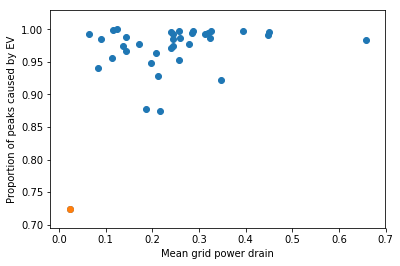

In [394]:
plt.scatter(np.mean(grid_signals,axis=1).iloc[np.where(ev_peak_ratio_1 > 0)],ev_peak_ratio_2[np.where(ev_peak_ratio_1 > 0)])
plt.scatter(np.mean(grid_signals.iloc[-2]),ev_peak_ratio_2[-2])
plt.xlabel("Mean grid power drain")
plt.ylabel("Proportion of peaks caused by EV")
plt.show()

In [946]:
metadata = pd.read_csv('C:\\Users\\bfesc\\Documents\\Master_thesis\\master_data\\dataport\\dataport-metadata.csv', 
                header = 0, index_col = 0)

In [965]:
peak_proportions_pv = []
peak_proportions_no_pv = []

for house in ev_signals.index:
    house_proportions = []
    for time in ev_signals.columns:
        if ev_signals[time].loc[house] > 1:
            house_proportions.append(ev_signals[time].loc[house]/grid_signals[time].loc[house])
    
    if len(house_proportions) > 0:
        if pd.isna(metadata['pv'].loc[house]):
            peak_proportions_no_pv.append(house_proportions)
        else:
            peak_proportions_pv.append(house_proportions)
print(len(peak_proportions_pv))
print(len(peak_proportions_no_pv))

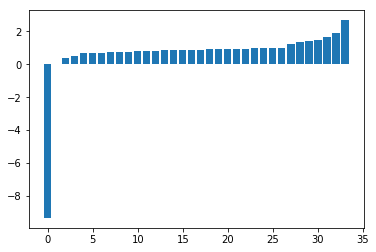

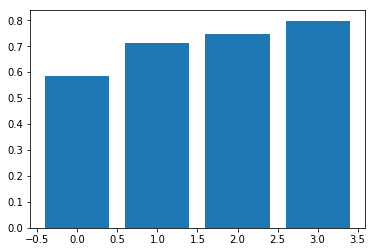

In [966]:
mean_props_pv = np.zeros(len(peak_proportions_pv))

for i in range(len(peak_proportions_pv)):
    mean_props_pv[i] += np.mean(peak_proportions_pv[i])

plt.bar(np.arange(len(mean_props_pv)), np.sort(mean_props_pv))
plt.show()

mean_props_no_pv = np.zeros(len(peak_proportions_no_pv))

for i in range(len(peak_proportions_no_pv)):
    mean_props_no_pv[i] += np.mean(peak_proportions_no_pv[i])

plt.bar(np.arange(len(mean_props_no_pv)), np.sort(mean_props_no_pv))
plt.show()

-9.33168440787
5.038176489159623
4.899005109728192
3.033773631204459
7.983456488452728
1.5369628101482526
3.000479099245913
2.406852372734315
1.2563144617882498
3.6561336045221142
3.177753273364672
3.494766483203849
3.8643297255228477
0.8767566053372207
-0.6092711223152812
0.1919664434697042


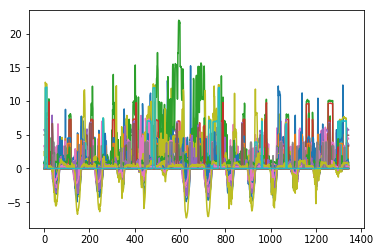

In [991]:
print(mean_props_pv[20])
for i in range(20,35):
    plt.plot(grid_signals.iloc[i][:24*14*4].values)
    plt.plot(ev_signals.iloc[i][:24*14*4].values, alpha=0.9)
    print(np.mean(grid_signals.iloc[i])/np.mean(ev_signals.iloc[i]))
plt.show()

This may be interesting.<br>
**Going forward:**<br>
Locate houses with EV<br>
Approximate number of EVs in aggregates<br>
Downsampling to 1 hour<br>
